<a href="https://colab.research.google.com/github/jeremysb1/xgboost/blob/main/xgboost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am building a model to predict prices using a regression-based approach with XGBoost.

In [1]:
import pandas as pd
summary_listings = pd.read_csv("/content/drive/MyDrive/XGBoost/listings.csv")

In [2]:
summary_listings.dtypes

,0
id,int64
name,object
host_id,int64
host_name,object
neighbourhood_group,float64
neighbourhood,object
latitude,float64
longitude,float64
room_type,object
price,int64


In [3]:
summary_listings['name'].iloc[0]

'Rental unit in Sumida · ★4.77 · 1 bedroom · 2 beds · 1 bath'

Extracting information from text descriptions:

In [4]:
import re

classification_list = ['aparthotel', 'barn', 'bed and breakfast', 'boutique hotel',
                       'bungalow', 'cabin', 'camper/rv', 'chalet', 'condo', 'cottage',
                       'earthen home', 'farm stay', 'guest suite', 'guesthouse', 'home',
                       'hostel', 'hotel', 'houseboat', 'hut', 'loft', 'place to stay',
                       'rental unit', 'resort', 'ryokan', 'serviced apartment',
                       'tiny home', 'townhouse', 'treehouse', 'vacation home', 'villa']

summary_listings = summary_listings.assign(
    type_of_accommodation=(summary_listings['name']
                           .str.extract(f"({'|'.join(classification_list)})",
                                        flags=re.IGNORECASE)),
    area_of_tokyo=(summary_listings['name']
                   .str.extract(r'in\s(.*?)\s·',
                                flags=re.IGNORECASE)),
    score=(summary_listings['name']
           .str.extract(r'★(\d+\.\d+)', flags=re.IGNORECASE)
           .astype(float)),
    number_of_bedrooms=(summary_listings['name']
                        .str.extract(r'(\d+)\s*(?:bedroom|bedrooms)',
                                     flags=re.IGNORECASE)
                        .fillna(0)
                        .astype(int)),
    number_of_beds=(summary_listings['name']
                    .str.extract(r'(\d+)\s+(?:beds?\b)',
                                 flags=re.IGNORECASE)
                    .fillna(0)
                    .astype(int)),
    number_of_baths=(summary_listings['name']
                     .str.extract(r'(?P<baths>\d+)\s*(shared\s+)?(?:half-)?baths?\b',
                                  flags=re.IGNORECASE)["baths"]
                     .fillna(0)
                     .astype(int)),
)

In [5]:
import numpy as np
from datetime import datetime

summary_listings = summary_listings.assign(
    is_new = (summary_listings['name']
              .str.lower()
              .str.contains('new', case=False)
              .astype(int)),
    is_studio = (summary_listings['name']
                 .str.lower()
                 .str.contains('studio', case=False)
                 .astype(int)),
    has_shared_bath = (summary_listings['name']
                 .str.lower()
                 .str.contains('shared', case=False)
                 .astype(int)),
    has_half_bath = (summary_listings['name']
                 .str.lower()
                 .str.contains('half', case=False)
                 .astype(int)),
)

summary_listings['days_since_last_review'] = (datetime.today() - pd.to_datetime(summary_listings['last_review'])).dt.days
summary_listings['days_since_last_review'] = (summary_listings['days_since_last_review'] -
                                              summary_listings['days_since_last_review'].min())

zero_reviews = summary_listings['number_of_reviews'] == 0
ratio = summary_listings['number_of_reviews_ltm'] / summary_listings['number_of_reviews']
summary_listings['number_of_reviews_ltm'] = np.where(zero_reviews, 0, ratio)

Creating the target from daily listings:

In [6]:
calendar = pd.read_csv("/content/drive/MyDrive/XGBoost/calendar.csv")

calendar["adjusted_price"] = calendar["adjusted_price"].apply(lambda x: float(x.replace('$', '').replace(',', '')))

price_stats = (calendar.groupby('listing_id')['adjusted_price']
                       .agg(['mean', 'min', 'max']))


In [7]:
price_stats.head()

,mean,min,max
listing_id,,,
197677,12000.000000,12000.0,12000.0
776070,8902.000000,8902.0,8902.0
905944,24680.221918,23740.0,29675.0
1016831,20378.082192,15000.0,25000.0
1196177,22127.671233,4500.0,30000.0


Creating a high cardinality geographical feature:

In [8]:
def bin_2_cat(feature, bins=32):
    min_value = feature.min()
    bin_size = (feature.max() - min_value) / bins
    return ((feature - min_value) / bin_size).astype(int)

summary_listings['coordinates'] = (bin_2_cat(summary_listings['latitude']) * 1000 +
                                  bin_2_cat(summary_listings['longitude']))

print(summary_listings['coordinates'].nunique())

325


Creating a feature comparing the location of our Airbnb accommodation with the area of the Imperial Palace because of its importanceon real estate valuations.

In [9]:
imperial_palace_lat = 35.6841822633
imperial_palace_lon = 139.751471994

def degrees_to_meters(distance_degrees, latitude):
    conversion_factor = 111000
    distance_meters = (distance_degrees * conversion_factor
                       * np.cos(np.radians(latitude)))
    return distance_meters

distance_degrees = (np.abs(summary_listings['latitude'] - imperial_palace_lat) +
                    np.abs(summary_listings['longitude'] - imperial_palace_lon))

summary_listings['imperial_palace_distance'] = degrees_to_meters(distance_degrees,
                                                                 summary_listings['latitude'])

In [10]:
summary_listings.imperial_palace_distance.mean()

7979.657691732742

The average distance to the Imperial Palace is around 7,9 kilometers.

Identifying the listing that is located nearest to the Imperial Palace:

In [11]:
(summary_listings[['id', 'name', 'neighbourhood', 'imperial_palace_distance']].iloc[np.argmin(summary_listings['imperial_palace_distance'])])

,9883
id,874407512426725982
name,Home in Shibuya City · ★4.64 · 3 bedrooms · 6 beds · 1 bath
neighbourhood,Chiyoda Ku
imperial_palace_distance,137.394271


Enriching the dataset with a csv file from kaggle showing the proximity of venues adding value to an accommodation.

In [12]:
from sklearn.neighbors import KDTree

relevant_spots = pd.read_csv("/content/drive/MyDrive/XGBoost/relevant_spots_Tokyo.csv")

venue_categories = ['Convenience Store', 'Train Station', 'Airport', 'Bus Station', 'Subway']

min_distances = {'listing_id': summary_listings['id']}

for venue in venue_categories:
    venue_filter = relevant_spots['venueCategory'] == venue
    venues = relevant_spots[['latitude', 'longitude']][venue_filter]
    tree = KDTree(venues, metric='manhattan')
    distance, index = tree.query(summary_listings[['latitude', 'longitude']], k=1)
    min_distances['nearest_' + venue.lower().replace(" ", "_")] = degrees_to_meters(np.ravel(distance), summary_listings['latitude'])

min_distances = pd.DataFrame(min_distances)

In [13]:
min_distances.head()

,listing_id,nearest_convenience_store,nearest_train_station,nearest_airport,nearest_bus_station,nearest_subway
0,197677,475.837692,666.488917,8326.122756,829.211343,1733.788985
1,776070,114.974697,384.929313,5430.623850,453.968550,784.313916
2,905944,155.409734,268.125319,2929.393383,783.601883,999.752343
3,1016831,389.067861,377.813210,2914.601177,365.480803,1764.993415
4,1196177,838.151520,243.734144,8538.784439,732.718147,1084.853768


Finalizing the predictive features and their target:

In [14]:
summary_listings_features = [
    'neighbourhood',
    'coordinates',
    'room_type',
    'minimum_nights', 'number_of_reviews', 'days_since_last_review',
    'reviews_per_month', 'calculated_host_listings_count',
    'availability_365', 'number_of_reviews_ltm',
    'number_of_bedrooms', 'number_of_beds', 'number_of_baths',
    'type_of_accommodation', 'score', 'is_new',
    'is_studio', 'has_shared_bath', 'has_half_bath',
    'imperial_palace_distance'
]

summarized = summary_listings[['id'] + summary_listings_features].rename({'id': 'listing_id'}, axis=1)

X = summarized.merge(min_distances, on='listing_id').set_index('listing_id')

X = X.reindex(price_stats.index)
price_stats_ordered = price_stats.reindex(X.index)
y = price_stats_ordered['mean'].copy()

In [15]:
X.head()

,neighbourhood,coordinates,room_type,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,is_new,is_studio,has_shared_bath,has_half_bath,imperial_palace_distance,nearest_convenience_store,nearest_train_station,nearest_airport,nearest_bus_station,nearest_subway
listing_id,,,,,,,,,,,,,,,,,,,,,
197677,Sumida Ku,20028,Entire home/apt,3,174,42.0,1.19,1,39,0.045977,...,0,0,0,0,9687.728076,475.837692,666.488917,8326.122756,829.211343,1733.788985
776070,Kita Ku,22026,Private room,3,248,28.0,1.88,1,116,0.072581,...,0,0,1,0,6483.053730,114.974697,384.929313,5430.623850,453.968550,784.313916
905944,Shibuya Ku,16022,Entire home/apt,3,194,13.0,1.52,5,166,0.046392,...,0,0,0,0,7069.339820,155.409734,268.125319,2929.393383,783.601883,999.752343
1016831,Setagaya Ku,14022,Private room,30,256,6.0,2.01,1,53,0.175781,...,0,0,1,0,9588.347677,389.067861,377.813210,2914.601177,365.480803,1764.993415
1196177,Adachi Ku,23027,Private room,2,100,5.0,0.81,1,112,0.050000,...,0,0,1,0,9591.131160,838.151520,243.734144,8538.784439,732.718147,1084.853768


Checking for any missing data:

In [16]:
X.isna().sum()

,0
neighbourhood,0
coordinates,0
room_type,0
minimum_nights,0
number_of_reviews,0
days_since_last_review,1458
reviews_per_month,1458
calculated_host_listings_count,0
availability_365,0
number_of_reviews_ltm,0


In [17]:
(X.number_of_reviews==0).sum()

1458

In [18]:
X[["days_since_last_review", "reviews_per_month", "score"]].describe()

,days_since_last_review,reviews_per_month,score
count,10775.000000,10775.000000,9590.000000
mean,97.595360,1.520293,4.680880
std,247.982866,1.654974,0.273886
min,0.000000,0.020000,2.000000
25%,10.000000,0.610000,4.570000
50%,23.000000,1.150000,4.740000
75%,55.000000,2.000000,4.860000
max,1964.000000,53.330000,5.000000


In [19]:
X.fillna(-1, inplace=True)

Preparing a panel of boxplots to be inspected for extreme values:

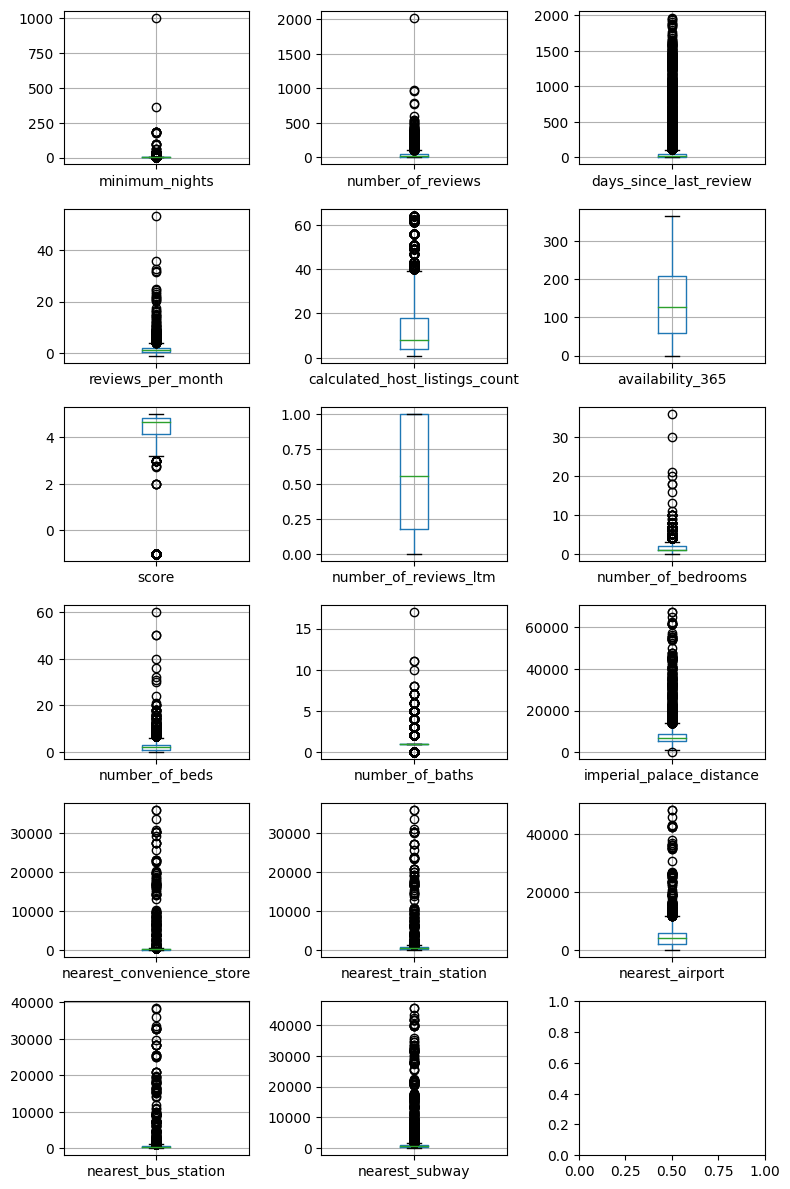

In [20]:
import matplotlib.pyplot as plt

numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score',
           'number_of_reviews_ltm', 'number_of_bedrooms',
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance',
           'nearest_convenience_store','nearest_train_station', 'nearest_airport',
           'nearest_bus_station', 'nearest_subway']

num_plots = len(numeric)
num_rows = (num_plots + 2) // 3
num_cols = min(num_plots, 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12))
axes = axes.flatten()

for i, feat in enumerate(numeric):
    X[[feat]].boxplot(ax=axes[i])

fig.tight_layout()
plt.show()

Winsorizing extreme values:

<Axes: >

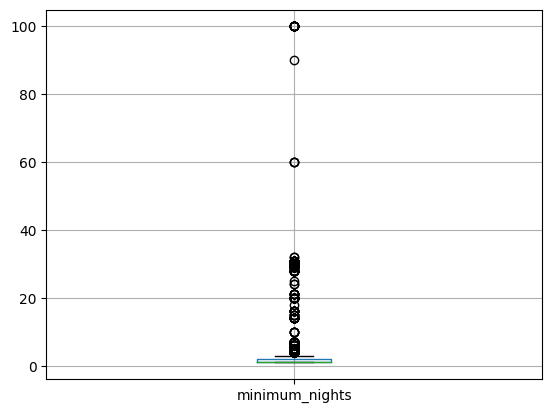

In [21]:
from scipy.stats.mstats import winsorize

lower_cut_percentile = 0.00
upper_cut_percentile = 0.001

X['minimum_nights'] = winsorize(X['minimum_nights'].values, limits=(lower_cut_percentile, upper_cut_percentile))

X[['minimum_nights']].boxplot()

<Axes: >

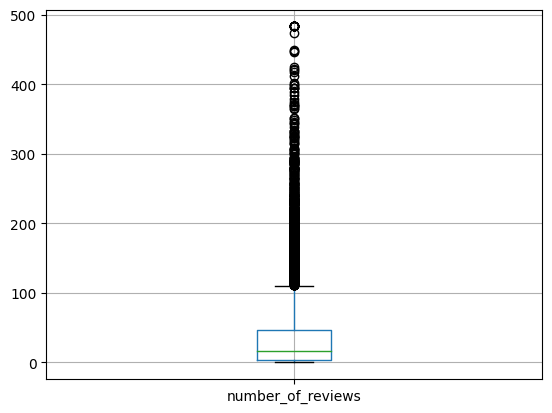

In [22]:
X['number_of_reviews'] = winsorize(X['number_of_reviews'].values, limits=(lower_cut_percentile, upper_cut_percentile))

X[['number_of_reviews']].boxplot()

Being a regression problem, I am figuring out the mean and the range of the target:

In [23]:
print(f"minimum: {y.min()}")
print(f"average: {y.mean().round(2)}")
print(f"maximum: {y.max()}")

minimum: 1500.0
average: 37352.69
maximum: 5202583.378082192


In [24]:
perc = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in perc:
    print(f"percentile {p:2}: {np.percentile(y, p).round(2)}")

percentile  1: 2960.25
percentile  5: 5020.38
percentile 10: 7322.82
percentile 25: 11969.86
percentile 50: 20000.0
percentile 75: 39367.88
percentile 90: 63203.12
percentile 95: 79614.91
percentile 99: 528215.33


In [25]:
valid_samples = (y >= 5020) & (y <= 78914)

Plotting the target distribution:

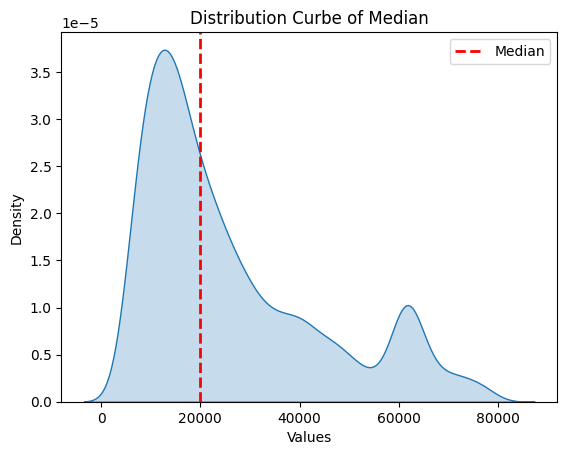

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

valid_y = y[valid_samples]
sns.kdeplot(valid_y, fill=True)

median = np.median(valid_y)
plt.axvline(median, color='r', linestyle='--', linewidth=2, label='Median')

plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution Curbe of Median')
plt.legend()
plt.show()

In [27]:
X = X[valid_samples]
y = y[valid_samples]

In [28]:
X['neighbourhood'].value_counts()

,count
neighbourhood,
Shinjuku Ku,2260
Taito Ku,1411
Sumida Ku,1298
Toshima Ku,1073
Shibuya Ku,727
Minato Ku,423
Setagaya Ku,385
Ota Ku,385
Nakano Ku,345


Using a KDTree to match each area with less than 30 accommodations with its nearest area with more than 30:

In [29]:
neighbourhoods = (summary_listings[['neighbourhood', 'latitude', 'longitude']]
           .groupby('neighbourhood')
           .agg({'latitude': 'mean', 'longitude': 'mean', 'neighbourhood': 'count'}))

less_than_30 = neighbourhoods[neighbourhoods['neighbourhood'] < 30]
more_than_30 = neighbourhoods[neighbourhoods['neighbourhood'] > 30]

kdtree = KDTree(more_than_30[['latitude', 'longitude']])
change_list = {}

for i in range(len(less_than_30)):
    row = less_than_30.iloc[[i]]
    _, idx = kdtree.query(row[['latitude', 'longitude']])
    change_list[row.index[0]] = more_than_30.index[idx[0, 0]]

X["neighbourhood_more_than_30"] = X["neighbourhood"].replace(change_list)

In [30]:
print(change_list)
print(X["neighbourhood_more_than_30"].value_counts())

{'Akiruno Shi': 'Fuchu Shi', 'Akishima Shi': 'Fuchu Shi', 'Chofu Shi': 'Fuchu Shi', 'Fussa Shi': 'Fuchu Shi', 'Hachioji Shi': 'Fuchu Shi', 'Hamura Shi': 'Fuchu Shi', 'Higashimurayama Shi': 'Fuchu Shi', 'Hino Shi': 'Fuchu Shi', 'Hinohara Mura': 'Fuchu Shi', 'Inagi Shi': 'Fuchu Shi', 'Kodaira Shi': 'Fuchu Shi', 'Koganei Shi': 'Fuchu Shi', 'Kokubunji Shi': 'Fuchu Shi', 'Komae Shi': 'Setagaya Ku', 'Kunitachi Shi': 'Fuchu Shi', 'Machida Shi': 'Fuchu Shi', 'Mitaka Shi': 'Suginami Ku', 'Musashimurayama Shi': 'Fuchu Shi', 'Musashino Shi': 'Suginami Ku', 'Nishitokyo Shi': 'Suginami Ku', 'Okutama Machi': 'Fuchu Shi', 'Ome Shi': 'Fuchu Shi', 'Tachikawa Shi': 'Fuchu Shi', 'Tama Shi': 'Fuchu Shi'}
neighbourhood_more_than_30
Shinjuku Ku      2260
Taito Ku         1411
Sumida Ku        1298
Toshima Ku       1073
Shibuya Ku        727
Minato Ku         423
Setagaya Ku       394
Ota Ku            385
Nakano Ku         345
Kita Ku           309
Suginami Ku       273
Chuo Ku           257
Katsushika Ku  

defining a stratified cross-validation strategy:

In [31]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"])

In [32]:
print(cv_splits)

<generator object _BaseKFold.split at 0x7c8bd1f0bed0>


##  Preparing the pipeline

Classifying the different kinds of features that we will be using into categorical features, numeric, and binary features:

In [33]:
categorical = ['room_type', 'neighbourhood_more_than_30', 'type_of_accommodation', 'coordinates']
numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score',
           'number_of_reviews_ltm', 'number_of_bedrooms',
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance',
           'nearest_convenience_store','nearest_train_station', 'nearest_airport',
           'nearest_bus_station', 'nearest_subway']
binary = ['is_new', 'is_studio', 'has_shared_bath', 'has_half_bath']


In [34]:
for feat in categorical:
    print(f"{feat} has {X[feat].nunique()} unique values")

room_type has 4 unique values
neighbourhood_more_than_30 has 24 unique values
type_of_accommodation has 31 unique values
coordinates has 302 unique values


In [35]:
onehot_encoding = ['room_type']
ordinal_encoding = ['neighbourhood_more_than_30', 'type_of_accommodation']
target_encoding = ['coordinates']

defining column transformations:

In [36]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00


In [37]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder

onehot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_enconder = OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=np.nan)
target_encoder = TargetEncoder(cols=target_encoding,
                               handle_unknown="value", smoothing=0.5)

column_transform = ColumnTransformer(
    [('onehot_encoding', onehot_encoder, onehot_encoding),
     ('ordinal_encoding', ordinal_enconder, ordinal_encoding),
     ('target_encoding', target_encoder, target_encoding),
     ('numeric', 'passthrough', numeric),
     ('binary', 'passthrough', binary)],
    remainder='drop',
    verbose_feature_names_out=True,
    sparse_threshold=0.0)


In [38]:
for col in ordinal_encoding:
    print(f"Column '{col}' data types:", X[col].apply(type).unique())

Column 'neighbourhood_more_than_30' data types: [<class 'str'>]
Column 'type_of_accommodation' data types: [<class 'str'> <class 'int'>]


In [39]:
X['type_of_accommodation'] = X['type_of_accommodation'].astype(str)

In [40]:
Xt = column_transform.fit_transform(X, y)
column_transform.get_feature_names_out()

array(['onehot_encoding__room_type_Entire home/apt',
       'onehot_encoding__room_type_Hotel room',
       'onehot_encoding__room_type_Private room',
       'onehot_encoding__room_type_Shared room',
       'ordinal_encoding__neighbourhood_more_than_30',
       'ordinal_encoding__type_of_accommodation',
       'target_encoding__coordinates', 'numeric__minimum_nights',
       'numeric__number_of_reviews', 'numeric__days_since_last_review',
       'numeric__reviews_per_month',
       'numeric__calculated_host_listings_count',
       'numeric__availability_365', 'numeric__score',
       'numeric__number_of_reviews_ltm', 'numeric__number_of_bedrooms',
       'numeric__number_of_beds', 'numeric__number_of_baths',
       'numeric__imperial_palace_distance',
       'numeric__nearest_convenience_store',
       'numeric__nearest_train_station', 'numeric__nearest_airport',
       'numeric__nearest_bus_station', 'numeric__nearest_subway',
       'binary__is_new', 'binary__is_studio', 'binary__has

In [41]:
data = pd.DataFrame(Xt, columns=column_transform.get_feature_names_out(), index=y.index)
data = data.assign(target=y).reset_index()
data.to_csv("/content/drive/MyDrive/XGBoost/airbnb_tokyo.csv", index=False)

## Building a baseline model

Linear regression baseline model with diagnostic plots:

predictiion range: -11449.98265642974 - 185251.87879717664
R-squared: 0.279
RMSE: 15467.736
MAE: 11914.801


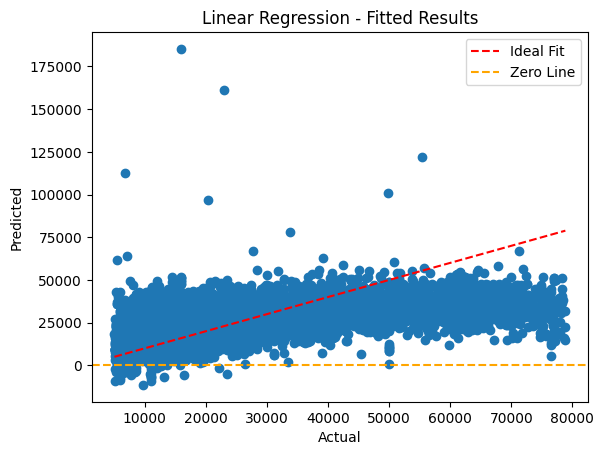

In [42]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lm = LinearRegression(fit_intercept=False)
lm.fit(Xt, y)

cv.splits = cv.split(X, y=X["neighbourhood_more_than_30"])
y_pred_cv = cross_val_predict(lm, Xt, y, cv=cv_splits)

print(f"predictiion range: {y_pred_cv.min()} - {y_pred_cv.max()}")

r2 = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae = mean_absolute_error(y, y_pred_cv)

print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

plt.scatter(y, y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.axhline(0, color='orange', linestyle='--', label='Zero Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression - Fitted Results')
plt.legend()
plt.show()


As a first step in examining the results, I calculate the percentage of predictions that are below or equal to zero; an unfeasible prediction because listings should be positive:

In [43]:
(y_pred_cv <= 0).sum() / len(y_pred_cv)

0.003727950536461175

Ideally, predictions should be greater than zero and in a linear model that could be achieved by a target transformation, for instance, a logarithmic transformation.

However, the role of a baseline model is not to be a perfect model but just a model to highlight challenges in the data and be a helpful comparison for more sophisticated models.



locating the rows that are positive outliers:

In [44]:
print(np.where(y_pred_cv > 100_000))

(array([ 619, 1248, 5341, 7977, 9923]),)


checking negative outliers:

In [45]:
print(np.where(y_pred_cv < -25_000))


(array([], dtype=int64),)


inspection of the coefficients:

In [46]:
def report_case(model, data, feature_names, case_no):
    case_values = data[case_no]
    coef_values = case_values * model.coef_
    for feature_name, value, coef_value in zip(feature_names, case_values, coef_values):
        print(f"{feature_name:50s} ({value:10.2f}) : {coef_value:+0.2f}")
    print("-" * 80)
    print(" "*66 + f"{np.sum(coef_values):+0.2f}")


In [47]:
report_case(model=lm,
            data=Xt,
            feature_names=column_transform.get_feature_names_out(),
            case_no=9923)


onehot_encoding__room_type_Entire home/apt         (      0.00) : -0.00
onehot_encoding__room_type_Hotel room              (      0.00) : -0.00
onehot_encoding__room_type_Private room            (      0.00) : -0.00
onehot_encoding__room_type_Shared room             (      1.00) : -11793.48
ordinal_encoding__neighbourhood_more_than_30       (     12.00) : +950.47
ordinal_encoding__type_of_accommodation            (     17.00) : -1589.23
target_encoding__coordinates                       (  26424.13) : +23784.93
numeric__minimum_nights                            (      1.00) : -186.55
numeric__number_of_reviews                         (     25.00) : -366.09
numeric__days_since_last_review                    (      3.00) : -4.54
numeric__reviews_per_month                         (     25.00) : +8211.67
numeric__calculated_host_listings_count            (      1.00) : +88.91
numeric__availability_365                          (    269.00) : +9385.22
numeric__score                          

In conclusion:

 The baseline model has signaled that successfully solving the problem presented by the Tokyo Airbnb dataset requires a better fitting mode that can handle positive predictions (they should be necessarily positive) and can represent non-linear relationships and interactions between a particular characteristic of the accommodation (a large number of bedrooms indicate a hostel, a high number of minimum stay nights indicates an accommodation for seasonal tenants).

I will solve all these problems at once by using an XGBoost model, which should be able to deal with this data in a more sophisticated and smart way.



## Building a first tentative model

I train an XGBoost regressor, and test its out-of-fold cross-validation predictions:

prediction range: 3257.68408203125 - 100652.203125
R-squared: 0.654
RMSE: 10715.278
MAE: 6991.540


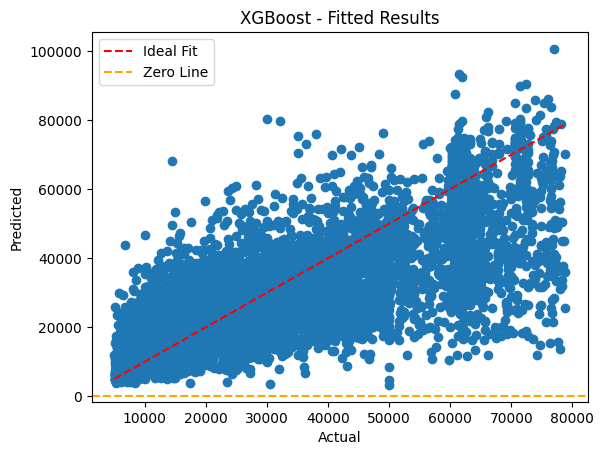

In [49]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

xgb = XGBRegressor(booster='gbtree',
                   objective='reg:gamma',
                   n_estimators=300,
                   max_depth=6)

cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"])
y_pred_cv = cross_val_predict(xgb, Xt, y, cv=cv_splits)

print(f"prediction range: {y_pred_cv.min()} - {y_pred_cv.max()}")

r2 = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae = mean_absolute_error(y, y_pred_cv)

print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

plt.scatter(y, y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.axhline(0, color='orange', linestyle='--', label='Zero Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost - Fitted Results')
plt.legend()
plt.show()

## Optimizing the model

I am going to use Optuna to efficiently explore a GBDT hyperparameter search space, adaptively choosing in a short set of rounds, based on the outcomes of the previous experiments, the next set of hyperparameters to be evaluated.

The following code performs hyperparameter optimization using Optuna for the previously tested XGBoost Regressor model to find the best hyperparameters that minimize the mean absolute error (MAE) of the model.

Finally, it then creates an XGBoost Regressor with the suggested hyperparameters at each test and performs cross-validation to evaluate the MAE.

In [51]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [52]:
import optuna

def objective(trial):

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror',
                                                             'reg:gamma',
                                                             'reg:tweedie']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    }

    if params['booster'] == 'gblinear':
        keys_to_remove = ["colsample_bytree", "max_depth", "min_child_weight", "subsample"]
        params = {key:value for key, value in params.items() if key not in keys_to_remove}

    if params['objective'] == 'reg:tweedie':
        # Must be between in range [1, 2) - 1=poisson 2=gamma
        params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.01, 1.99)

    xgb = XGBRegressor(**params)
    model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])
    cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"])

    cv_scores = cross_validate(estimator=model_pipeline,
                               X=X,
                               y=y,
                               scoring='neg_mean_absolute_error',
                               cv=cv_splits)

    cv_evaluation = np.mean(np.abs(cv_scores['test_score']))
    return cv_evaluation

sqlite_db = "sqlite:///sqlite.db"
study_name = "optimize_xgboost_tokyo_airbnb"
study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                            direction="minimize", load_if_exists=True)

study.optimize(objective, n_trials=100)
print(study.best_value)
print(study.best_params)

[I 2024-08-03 20:36:49,088] A new study created in RDB with name: optimize_xgboost_tokyo_airbnb
[I 2024-08-03 20:37:19,685] Trial 0 finished with value: 9223.252174838253 and parameters: {'booster': 'gbtree', 'objective': 'reg:tweedie', 'n_estimators': 282, 'learning_rate': 0.2462601051935867, 'subsample': 0.7851933059141916, 'colsample_bytree': 0.9368300264715128, 'max_depth': 2, 'min_child_weight': 4, 'reg_lambda': 0.06887512225444875, 'reg_alpha': 0.0006734151730573911, 'tweedie_variance_power': 1.3890740506607455}. Best is trial 0 with value: 9223.252174838253.
[I 2024-08-03 20:37:33,125] Trial 1 finished with value: 18610.835739552724 and parameters: {'booster': 'gblinear', 'objective': 'reg:gamma', 'n_estimators': 947, 'learning_rate': 0.3755501251375267, 'subsample': 0.8021716412289026, 'colsample_bytree': 0.3945088833834953, 'max_depth': 1, 'min_child_weight': 2, 'reg_lambda': 0.00041793594337708205, 'reg_alpha': 7.711356347991508e-08}. Best is trial 0 with value: 9223.25217483

6389.199835933243
{'booster': 'gbtree', 'objective': 'reg:tweedie', 'n_estimators': 964, 'learning_rate': 0.050248270654634435, 'subsample': 0.92123902797313, 'colsample_bytree': 0.9127039769210571, 'max_depth': 7, 'min_child_weight': 4, 'reg_lambda': 4.590879310302508e-08, 'reg_alpha': 0.8076491083325608, 'tweedie_variance_power': 1.7177300827936384}


In [53]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [54]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Training the final model

Having completed the optimization, I finish by testing the results directly by cross-validation and then training the model on all available data.

training the model with full data:

In [55]:
best_params = study.best_params
print(best_params)

xgb = XGBRegressor(**best_params)
model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])

cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"])

r2_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in cv_splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Mean cv R-squared: {np.mean(r2_scores):.3f}")
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

model_pipeline.fit(X, y)

{'booster': 'gbtree', 'objective': 'reg:tweedie', 'n_estimators': 964, 'learning_rate': 0.050248270654634435, 'subsample': 0.92123902797313, 'colsample_bytree': 0.9127039769210571, 'max_depth': 7, 'min_child_weight': 4, 'reg_lambda': 4.590879310302508e-08, 'reg_alpha': 0.8076491083325608, 'tweedie_variance_power': 1.7177300827936384}
Mean cv R-squared: 0.695
Mean cv RMSE: 10053.485
Mean cv MAE: 6389.200


Pipeline(steps=[('processing',
                 ColumnTransformer(sparse_threshold=0.0,
                                   transformers=[('onehot_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['neighbourhood_more_than_30',
                                                   'type_of_accommodation']),
                                                 ('target_encoding',
                                                  TargetEncoder(cols=['coordinat...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.050248270654634435, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=4, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=964, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

## Explaining the model with SHAP

SHAP values (SHapley Additive exPlanations) are a method that can explain the way predictions of machine learning models are built.

They are based on Shapley values, a cooperative game theory concept that fairly distributes each feature's 'credit' or 'importance' in a model's prediction for a specific data instance.

In other words, SHAP values allocate the contribution of each feature to the model's output using a simple additive formula.

In [57]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.0 MB/s eta 0:00:00


SHAP values as an XGBoost output:

In [58]:
from xgboost import DMatrix

booster = model_pipeline['xgb'].get_booster()

Xt = model_pipeline['processing'].transform(X)
feature_names = model_pipeline['processing'].get_feature_names_out()
Xd = DMatrix(Xt)

shap_values = booster.predict(Xd, pred_contribs=True)
preds = booster.predict(Xd)


In [61]:
np.prod(np.exp(shap_values[0])), preds[0]

(11214.094, 11214.123)

In [62]:
np.corrcoef(preds, np.prod(np.exp(shap_values), axis=1))

array([[1., 1.],
       [1., 1.]])

In [63]:
from shap import TreeExplainer

explainer = TreeExplainer(model_pipeline['xgb'], data=Xt, model_output='raw', feature_perturbation='interventional')
interventional_shap_values = explainer.shap_values(Xt)

100%|===================| 10990/10998 [17:03<00:00]       

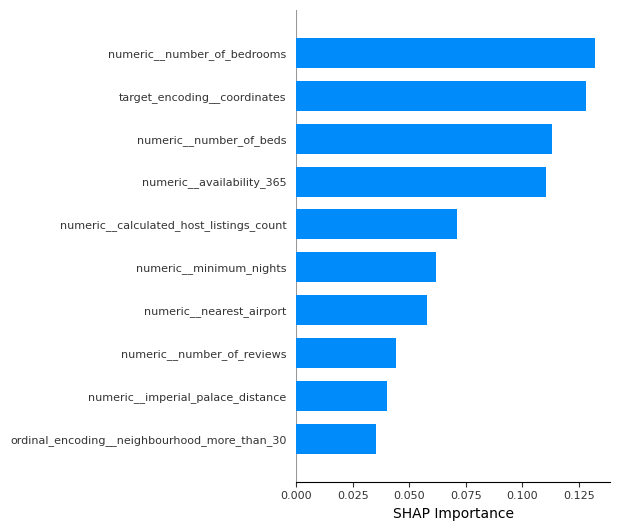

In [64]:
import shap

shap.summary_plot(shap_values[:,:-1], Xt, plot_type="bar",
                  feature_names=feature_names, max_display=10, show=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("SHAP Importance", fontsize=10)
plt.show()


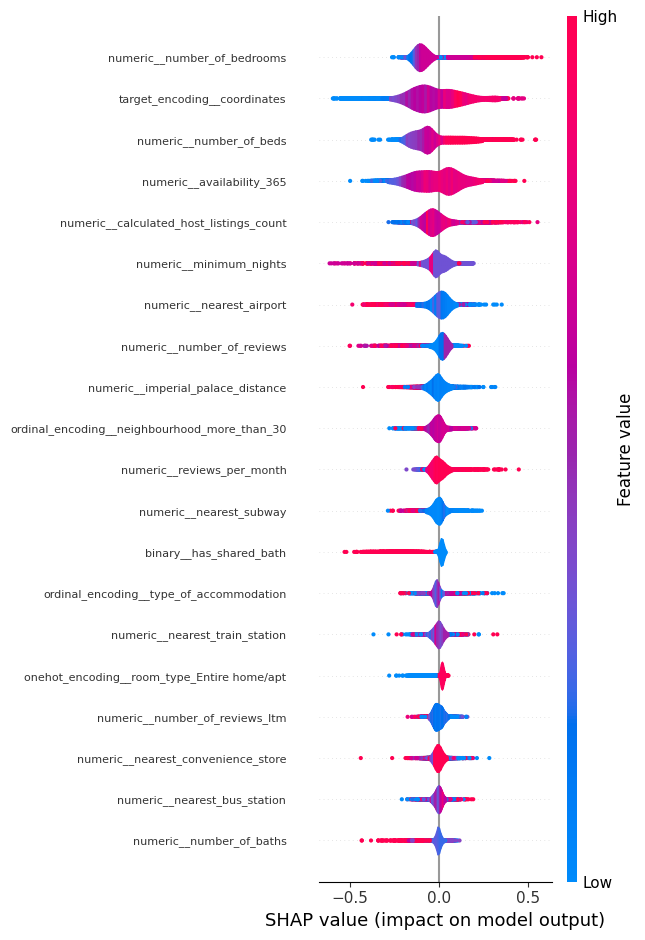

In [65]:
shap.summary_plot(shap_values[:,:-1], Xt,
                  plot_type="violin",
                  feature_names=feature_names, show=False)
plt.yticks(fontsize=8)
plt.show()
